In [1]:
import numpy as np
from numpy import random as rd
from hurst_fitting import *
from statsmodels.graphics.tsaplots import plot_acf
from ito_diffusion_1d import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,7),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
T = 0.5
SCHEME_STEPS = 250
N_KL = 500
LAGS = 20

# Current KL method only works for $ H>\frac{1}{2}$

## Benchmarking

In [4]:
fBM = FBM(x0=100.0, T=T, scheme_steps=SCHEME_STEPS, drift=0.0, vol=1.0, H=0.6, n_kl=N_KL)

In [5]:
fBM.method = 'vector'
%timeit fBM.simulate()

114 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
fBM.method = 'kl'
%timeit fBM.simulate()

33.5 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Check sample paths

In [7]:
fBM = FBM(x0=100.0, T=T, scheme_steps=SCHEME_STEPS, drift=0.0, vol=1.0, n_kl=N_KL)

In [8]:
df  = fBM.simulate()

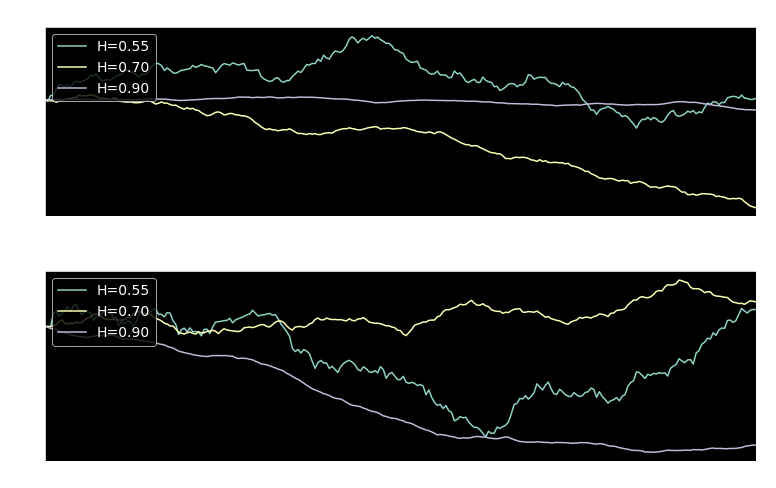

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1)

fBM = FBM(x0=0, T=T, scheme_steps=SCHEME_STEPS, drift=0, vol=1, n_kl=N_KL)

Hs = [0.55, 0.7, 0.9]

ax = axes[0]
fBM.method = 'vector'
for H in Hs:
    fBM.H = H
    df = fBM.simulate()
    df = df.rename(columns={'spot': 'H={:.2f}'.format(H)})    
    df.plot(kind='line', ax=ax)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
ax.legend(loc='upper left')
ax.set_title('Gaussian vector fBM')

ax = axes[1]
fBM.method = 'kl'
for H in Hs:
    fBM.H = H
    df = fBM.simulate()
    df = df.rename(columns={'spot': 'H={:.2f}'.format(H)})    
    df.plot(kind='line', ax=ax)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
ax.legend(loc='upper left')
ax.set_title('Karhunen-Loeve fBM')

plt.tight_layout()
plt.show()

## Check autocorrelation

In [10]:
fBM = FBM(x0=100.0, T=T, scheme_steps=SCHEME_STEPS, drift=0.0, vol=1.0, H=0.6, n_kl=N_KL)

In [11]:
fBM.method = 'vector'
df = fBM.simulate()
x = np.array(df.index)
y = np.array(df['spot'])
rets = y[1:]-y[:-1]

In [12]:
fBM.method = 'kl'
df_f = fBM.simulate()
x_f = np.array(df_f.index)
y_f = np.array(df_f['spot'])
rets_f = y_f[1:]-y_f[:-1]

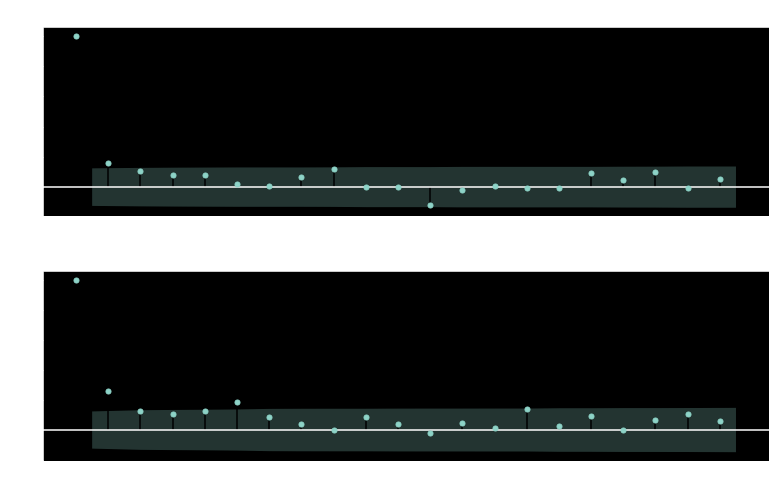

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1)
plot_acf(rets, lags=LAGS, ax = axes[0], zero=True, title='Gaussian vector fBM')
plot_acf(rets_f, lags=LAGS, ax = axes[1], zero=True, title='Karhunen-Loeve fBM')
plt.tight_layout()
plt.show()

## Check Hurst index fit

/home/sauxpa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/sauxpa/Documents/python_scripts/Quant/diffusions/hurst_fitting.py:43: RuntimeWarning: divide by zero encountered in power
  return 0.5*(np.abs(lag+1)**(2*H)+np.abs(lag-1)**(2*H)-2*np.abs(lag)**(2*H))
/home/sauxpa/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


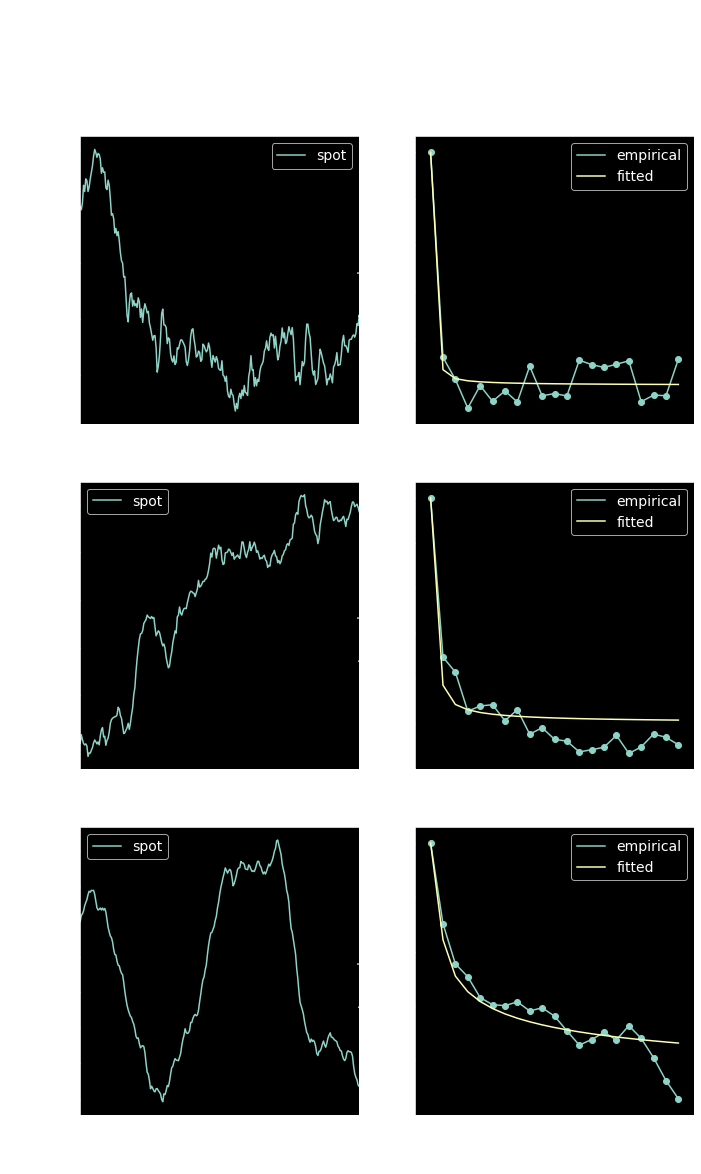

In [14]:
fig, axes = plt.subplots(figsize=(11, 18), nrows=3, ncols=2)

fBM = FBM(x0=100.0, T=T, scheme_steps=SCHEME_STEPS, drift=0.0, vol=1.0, method='vector')
fitter = Hurst_fitter(n_lags=LAGS)

Hs = [0.55, 0.7, 0.9]

for i, ax_row in enumerate(axes):
    H = Hs[i]
    fBM.H = H
    df = fBM.simulate()
    
    # initialize Hurst fitter
    fitter.df = df
    H_fit = fitter.fit()
    
    ax = ax_row[0]
    df.plot(kind='line', ax=ax)
    ax.set_xlabel('time\nH={:.2f}'.format(H))
    ax.set_ylabel('spot')
    ax.legend()

    ax = ax_row[1]
    ys = acf(fitter.df_inc, nlags=LAGS)
    ys_fit = fitter.autocorr_frac_noise_range(H_fit)
    ax.plot(fitter.lag_range, ys, label='empirical')
    ax.scatter(fitter.lag_range, ys, marker='o')
    ax.plot(fitter.lag_range, ys_fit, label='fitted')
        
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.set_xlabel('lag\nH={:.2f} (empirical) vs H={:.2f} (fitted) '.format(H, H_fit))
    ax.set_ylabel('autocorrelogram')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.legend(loc='upper right')

fig.suptitle('Gaussian vector fBM')
plt.show()

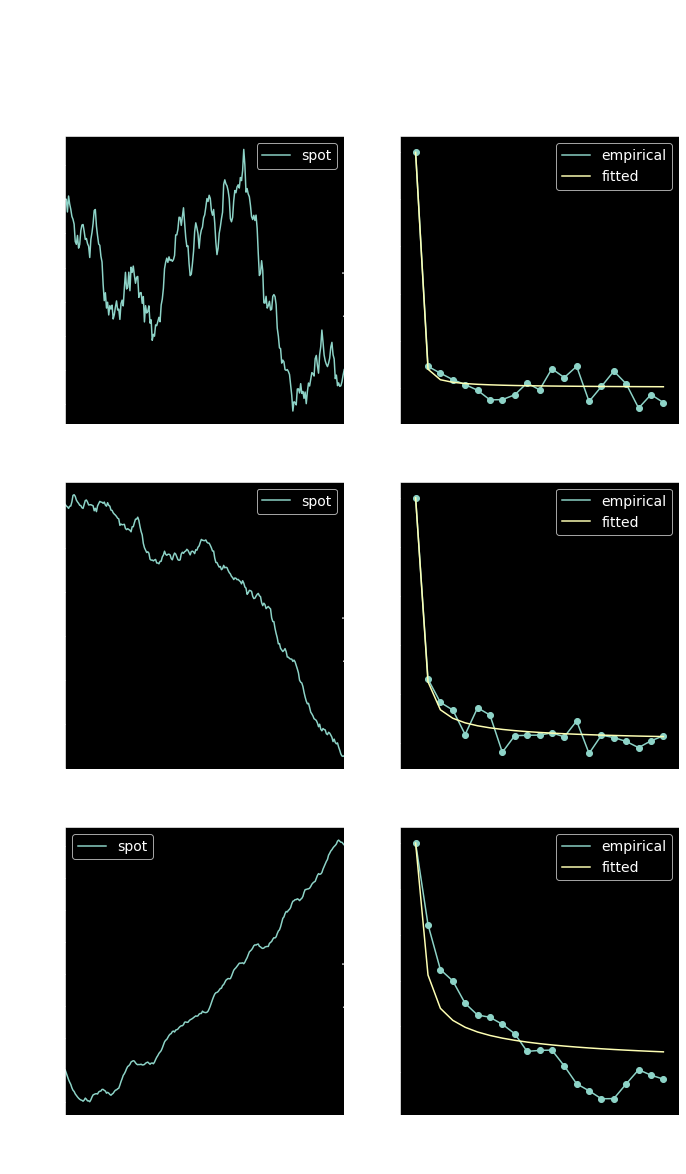

In [15]:
fig, axes = plt.subplots(figsize=(11, 18), nrows=3, ncols=2)

fBM = FBM(x0=100.0, T=T, scheme_steps=SCHEME_STEPS, drift=0.0, vol=1.0, method='kl', n_kl=N_KL)
fitter = Hurst_fitter(n_lags=LAGS)

Hs = [0.55, 0.7, 0.9]

for i, ax_row in enumerate(axes):
    H = Hs[i]
    fBM.H = H
    df = fBM.simulate()
    
    # initialize Hurst fitter
    fitter.df = df
    H_fit = fitter.fit()
    
    ax = ax_row[0]
    df.plot(kind='line', ax=ax)
    ax.set_xlabel('time\nH={:.2f}'.format(H))
    ax.set_ylabel('spot')
    ax.legend()

    ax = ax_row[1]
    ys = acf(fitter.df_inc, nlags=LAGS)
    ys_fit = fitter.autocorr_frac_noise_range(H_fit)
    ax.plot(fitter.lag_range, ys, label='empirical')
    ax.scatter(fitter.lag_range, ys, marker='o')
    ax.plot(fitter.lag_range, ys_fit, label='fitted')
        
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.set_xlabel('lag\nH={:.2f} (empirical) vs H={:.2f} (fitted) '.format(H, H_fit))
    ax.set_ylabel('autocorrelogram')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.legend(loc='upper right')

fig.suptitle('Karhunen-Loeve vector fBM')
plt.show()